# Hybrid models

A time series can be decomposed in the following additive terms:
`time_series = trend + seasonality + cycles + error`

We have studied ways of decomposing the time series by using simple models, such as a Linear Regression. We have also studied more complex regression models, mainly the ones based on trees that allow for a better map of seasonalities and cycles. What if we could create a model that is a hybrid of both linear regression models (to model trends) and trees, to model seasonalities?

There are two types of regression models: **feature transformers** and **target transformers**.

**Feature transformers** produce mathematical equations that map a series of input features into a target value. Therefore, these models are able to **extrapolate** for new feature values and achieve target values that were not possible in the training data. This means that we can model **trends** with this type of model. Typical feature transformer models would be Linear Regressions and Neural networks

**Target transformers**, on the other hand, use features to group similar models and the predicted target is calculated as an average of the target values of participants of that group. This characteristic produces target values that are always **bounded between target values in the training data**. Therefore these types of models, despite modelling non-linearities better, are **not able to extrapolate data**. Typical target transformers models would be Decision Trees, K-nearest neighbors, Random Forests and Gradient Boosting Machines (as they are tree-based models)

A **hybrid model** would typically use a linear regression model to extrapolate trends from data and later use a non-linear model to model seasonalities and cycles. There are two ways of doing that: stacking and boosting.

**Boosting**: Very similar to the Gradient Boosting methods, you can fit a Linear Regression model that predicts trends, then you subtract the predicted trend values from the original target values to create a "detrendended" target, which you later fit a non-linear model.

**Stacking**: Quite used in Neural networks, where you use the predicted trend value as an input to the neural network, usually with a negative value, to subtract trend values from additional layers

## Let's see in practice some of these properties

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
! ls inputs/

ar.csv
avocados.csv
book_sales.csv
co2.csv
elecdemand.csv
flu-trends.csv
reserve.csv
trig.csv
tunnel.csv
us-retail-sales.csv


In [3]:
! head -5 inputs/co2.csv

Date,CO2
1959-01-01,315.42
1959-02-01,316.31
1959-03-01,316.5
1959-04-01,317.56


In [4]:
co2 = pd.read_csv("./inputs/co2.csv", parse_dates=["Date"], index_col="Date")
print(co2.shape)
co2.head()

(468, 1)


,CO2
Date,
1959-01-01,315.42
1959-02-01,316.31
1959-03-01,316.50
1959-04-01,317.56
1959-05-01,318.13


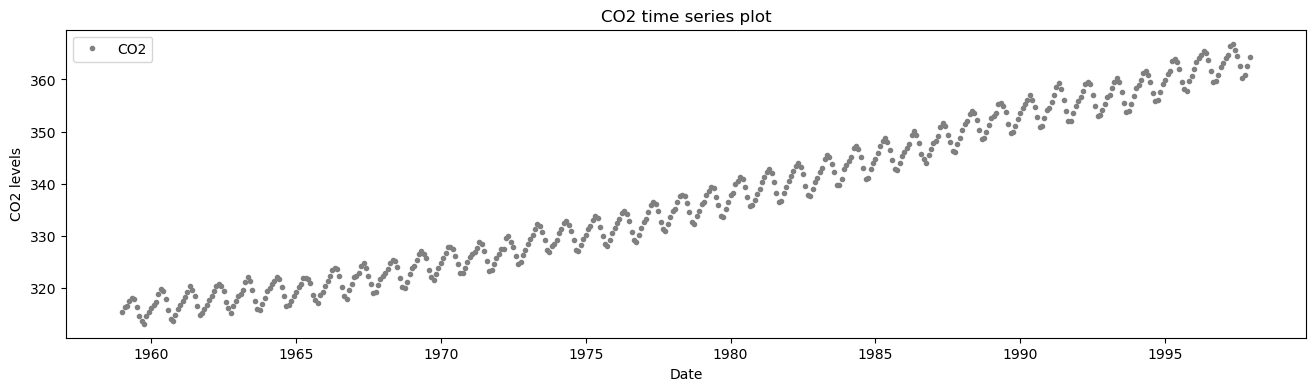

In [5]:
plot_params = {"figsize": (16,4)}
fig, ax = plt.subplots(**plot_params)
ax.plot(co2.index, co2.CO2, ".", color="0.5", label="CO2",)
ax.set_title("CO2 time series plot")
ax.set_xlabel("Date")
ax.set_ylabel("CO2 levels")
ax.legend()

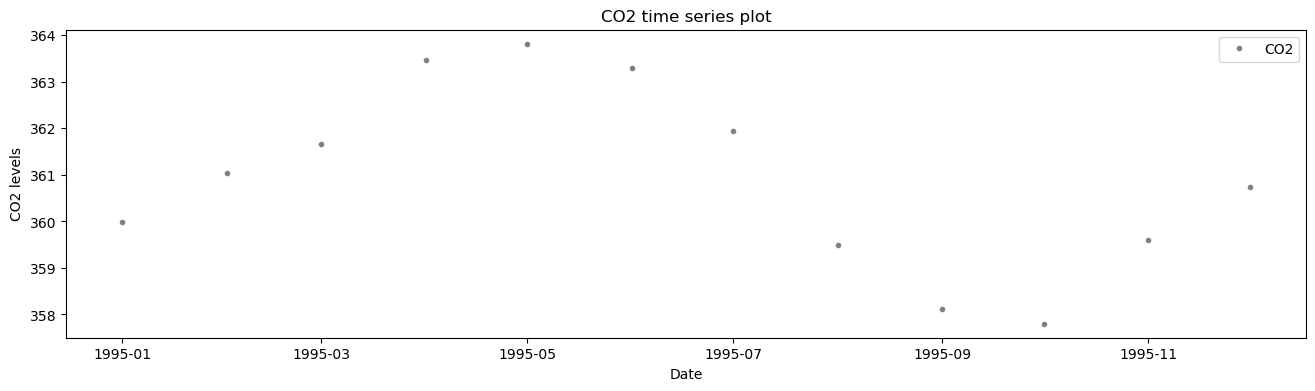

In [6]:
fig, ax = plt.subplots(**plot_params)
ax.plot(co2.loc["1995"].index, co2.loc["1995","CO2"], ".", color="0.5", label="CO2",)
ax.set_title("CO2 time series plot")
ax.set_xlabel("Date")
ax.set_ylabel("CO2 levels")
ax.legend()

The CO2 time series clearly presents common aspects of trend and annual seasonality, let's fit some models and plot residuals

In [7]:
from statsmodels.tsa.deterministic import DeterministicProcess, CalendarFourier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, train_test_split

In [8]:
from lightgbm import LGBMRegressor

In [9]:
# First we create the time step features
ts = co2.set_index(pd.PeriodIndex(co2.index, freq="M",))
ts.head()

,CO2
Date,
1959-01,315.42
1959-02,316.31
1959-03,316.50
1959-04,317.56
1959-05,318.13


In [10]:
# 3 years of test in the end of the time series
# tscv = TimeSeriesSplit(n_splits=2, test_size=36)
X_train_index, X_test_index, y_train, y_test = train_test_split(ts.index, ts["CO2"], test_size=48, shuffle=False)

In [11]:
dp = DeterministicProcess(X_train_index, constant=True, order=2, seasonal=True)
X_train = dp.in_sample()

In [12]:
X_test = dp.out_of_sample(steps=len(X_test_index),forecast_index=X_test_index)

In [13]:
X = pd.concat([X_train, X_test], axis=0)
y = pd.concat([y_train, y_test], axis=0)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(420, 14) (48, 14) (420,) (48,)


In [15]:
X_train.head()

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
Date,,,,,,,,,,,,,,
1959-01,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1959-02,1.0,2.0,4.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1959-03,1.0,3.0,9.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1959-04,1.0,4.0,16.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1959-05,1.0,5.0,25.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [16]:
X_test.head()

,const,trend,trend_squared,"s(2,12)","s(3,12)","s(4,12)","s(5,12)","s(6,12)","s(7,12)","s(8,12)","s(9,12)","s(10,12)","s(11,12)","s(12,12)"
Date,,,,,,,,,,,,,,
1994-01,1.0,421.0,177241.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994-02,1.0,422.0,178084.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994-03,1.0,423.0,178929.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994-04,1.0,424.0,179776.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1994-05,1.0,425.0,180625.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


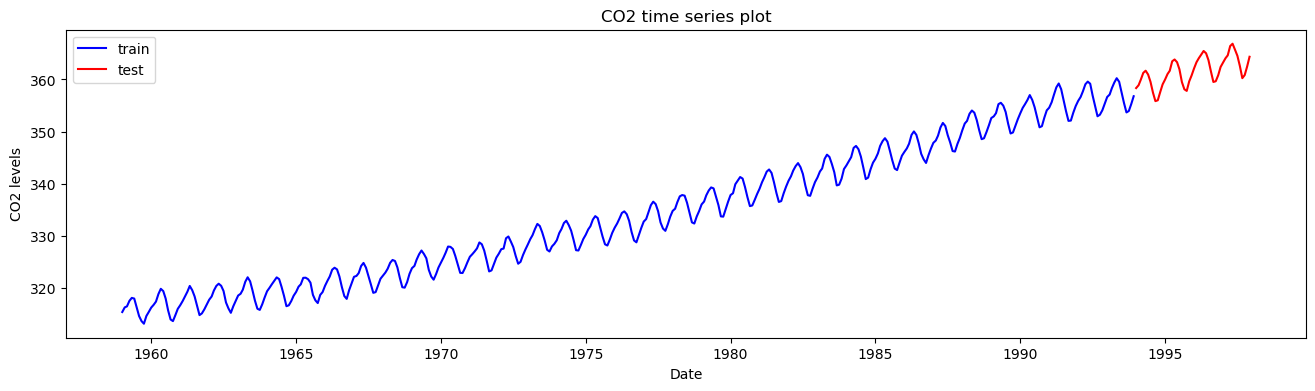

In [17]:
plot_params = {"figsize": (16,4)}
fig, ax = plt.subplots(**plot_params)
ax.plot(X_train.index.to_timestamp(), y_train, color="b", label="train",)
ax.plot(X_test.index.to_timestamp(), y_test, color="r", label="test",)
ax.set_title("CO2 time series plot")
ax.set_xlabel("Date")
ax.set_ylabel("CO2 levels")
ax.legend()

In [18]:
models = [("Linear Regression", LinearRegression(n_jobs=3, fit_intercept=False)),
          ("Decision Tree", DecisionTreeRegressor(random_state=0)),
          ("Random Forest",RandomForestRegressor(random_state=0, n_jobs=3)),
          ("LightGBM", LGBMRegressor(n_jobs=3))]

In [19]:
y_trends = []
for model in models:
    model[1].fit(X_train[["const","trend","trend_squared"]], y_train)
    y_trends.append((model[0], pd.Series(model[1].predict(X[["const","trend","trend_squared"]]), index = y.index, name="trend")))

In [20]:
def plot_predictions(y_train, y_test, y_trend, title, ax):
    y = pd.concat([y_train, y_test], axis="rows")
    
    ax.plot(y.index.to_timestamp(), y, ".",color="0.8", label="target",)
    ax.axvline(y_train.index.to_timestamp().max(), color='0.8', label="train/test limit")
    
    ax.plot(y_train.index.to_timestamp(), y_trend[y_train.index], color="b", label="train",)
    ax.plot(y_test.index.to_timestamp(), y_trend[y_test.index], color="r", label="test",)

    ax.set_title(title)
    ax.set_xlabel("Date")
    ax.set_ylabel("CO2 levels")
    ax.legend()

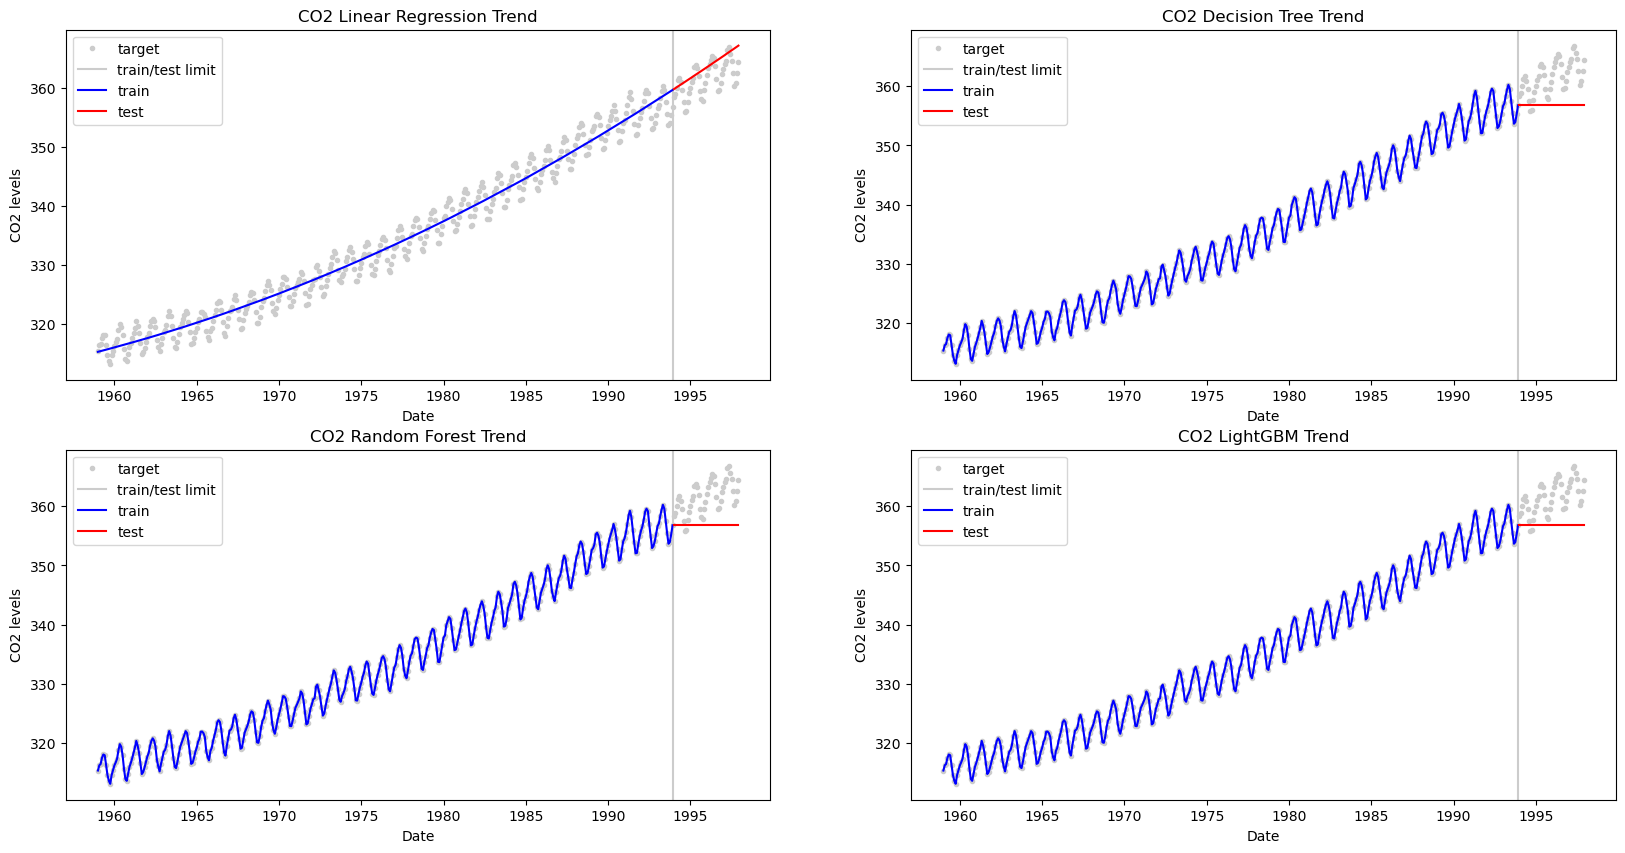

In [21]:
plot_params = {"figsize": (20,10)}
fig, axs = plt.subplots(2,2,**plot_params)

plot_predictions(y_train, y_test, y_trends[0][1], f"CO2 {y_trends[0][0]} Trend", axs[0][0])
plot_predictions(y_train, y_test, y_trends[1][1], f"CO2 {y_trends[1][0]} Trend", axs[0][1])
plot_predictions(y_train, y_test, y_trends[1][1], f"CO2 {y_trends[2][0]} Trend", axs[1][0])
plot_predictions(y_train, y_test, y_trends[1][1], f"CO2 {y_trends[3][0]} Trend", axs[1][1])

### Conclusions
As we can clearly see, Tree models cannot learn trends....

In [22]:
y_seasonalities = []

for model in models:
    model[1].fit(X_train.values, y_train)
    y_seasonalities.append((model[0], pd.Series(model[1].predict(X.values), index = y.index, name="seasonality")))

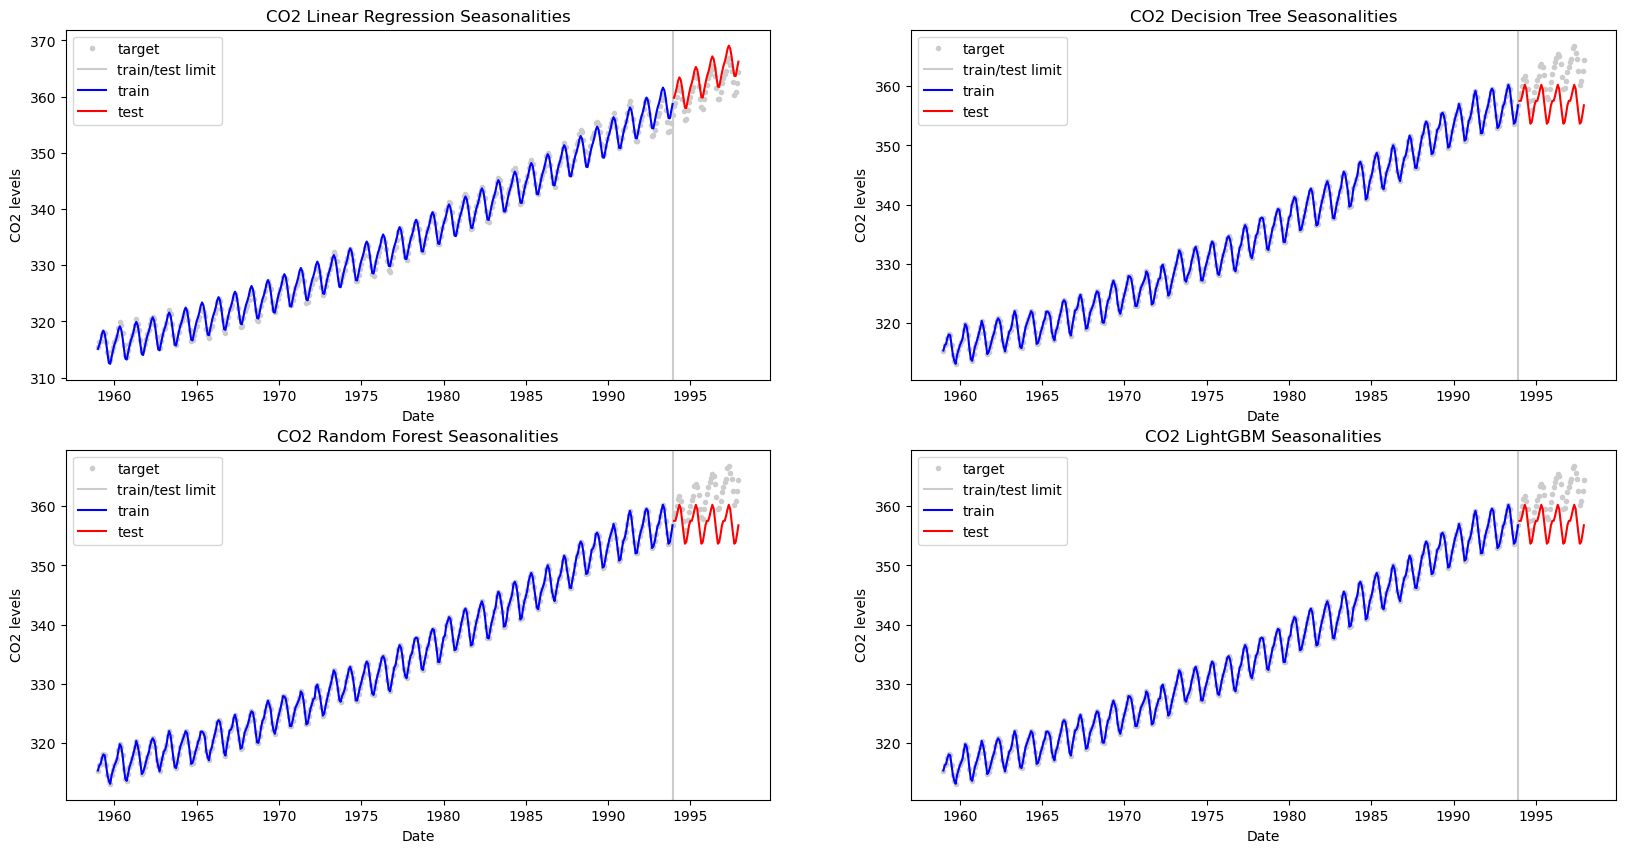

In [23]:
plot_params = {"figsize": (20,10)}
fig, axs = plt.subplots(2,2,**plot_params)

plot_predictions(y_train, y_test, y_seasonalities[0][1], f"CO2 {y_trends[0][0]} Seasonalities", axs[0][0])
plot_predictions(y_train, y_test, y_seasonalities[1][1], f"CO2 {y_trends[1][0]} Seasonalities", axs[0][1])
plot_predictions(y_train, y_test, y_seasonalities[1][1], f"CO2 {y_trends[2][0]} Seasonalities", axs[1][0])
plot_predictions(y_train, y_test, y_seasonalities[1][1], f"CO2 {y_trends[3][0]} Seasonalities", axs[1][1])

### Conclusions

Linear Regressions, on the other hand, can learn seasonalities... when given the certain input values

In [24]:
# We use our linear regression model to "detrend" time series 
y_detrend = y - y_trends[0][1]

Text(0, 0.5, 'CO2 levels')

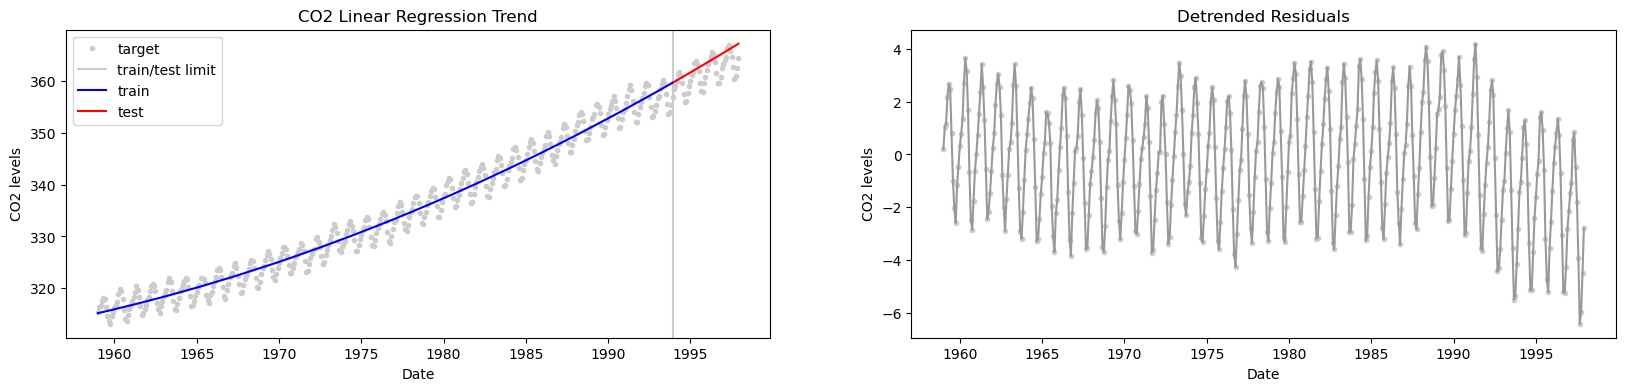

In [25]:
plot_params = {"figsize": (20,4)}
fig, axs = plt.subplots(1,2,**plot_params)

plot_predictions(y_train, y_test, y_trends[0][1], f"CO2 {y_trends[0][0]} Trend", axs[0])

axs[1].plot(y_detrend.index.to_timestamp(), y_detrend, ".", color="0.8", label="residuals")
axs[1].plot(y_detrend.index.to_timestamp(), y_detrend, color="0.6", label="residuals")
axs[1].set_title("Detrended Residuals")
axs[1].set_xlabel("Date")
axs[1].set_ylabel("CO2 levels")

### Conclusions

The de-trended residuals can show us 2 things: 
- There are annual seasonalities
- Thre are multi-year seasonalities that can be probably modeled through lag features (cycles)

In [26]:
y_detrend_train = y_detrend[y_train.index]
y_detrend_test = y_detrend[y_test.index]

In [27]:
X_detrend = X.drop(["const","trend","trend_squared"], axis=1)

for i in range (1, 13):
    X_detrend[f"LAG_{i}"] = y_detrend.shift(i).fillna(0)
    
X_detrend_train = X_detrend.loc[X_train.index]
X_detrend_test = X_detrend.loc[X_test.index]

In [28]:
y_detrend_seasonalities = []

for model in models:
    model[1].fit(X_detrend_train.values, y_detrend_train)
    y_detrend_seasonalities.append((model[0], pd.Series(model[1].predict(X_detrend.values), index = y.index, name="seasonality")))

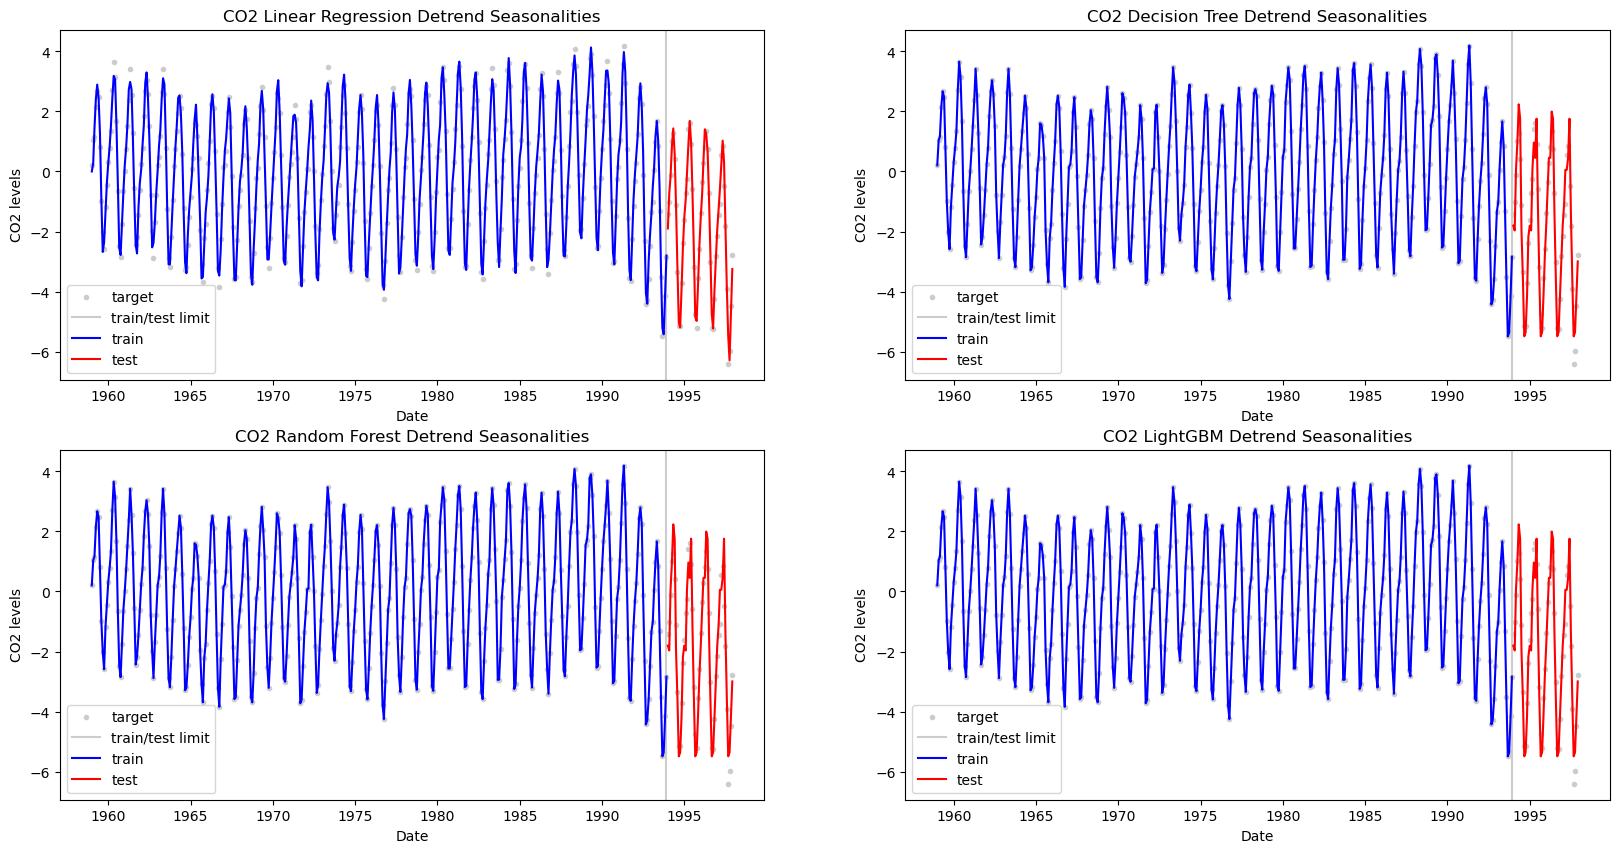

In [29]:
plot_params = {"figsize": (20,10)}
fig, axs = plt.subplots(2,2,**plot_params)

plot_predictions(y_detrend_train, y_detrend_test, y_detrend_seasonalities[0][1], f"CO2 {y_detrend_seasonalities[0][0]} Detrend Seasonalities", axs[0][0])
plot_predictions(y_detrend_train, y_detrend_test, y_detrend_seasonalities[1][1], f"CO2 {y_detrend_seasonalities[1][0]} Detrend Seasonalities", axs[0][1])
plot_predictions(y_detrend_train, y_detrend_test, y_detrend_seasonalities[1][1], f"CO2 {y_detrend_seasonalities[2][0]} Detrend Seasonalities", axs[1][0])
plot_predictions(y_detrend_train, y_detrend_test, y_detrend_seasonalities[1][1], f"CO2 {y_detrend_seasonalities[3][0]} Detrend Seasonalities", axs[1][1])

In [30]:
# Adds Linear regression trend for each detrend model
y_preds = [(y_detrend[0], y_trends[0][1] + y_detrend[1]) for y_detrend in y_detrend_seasonalities]

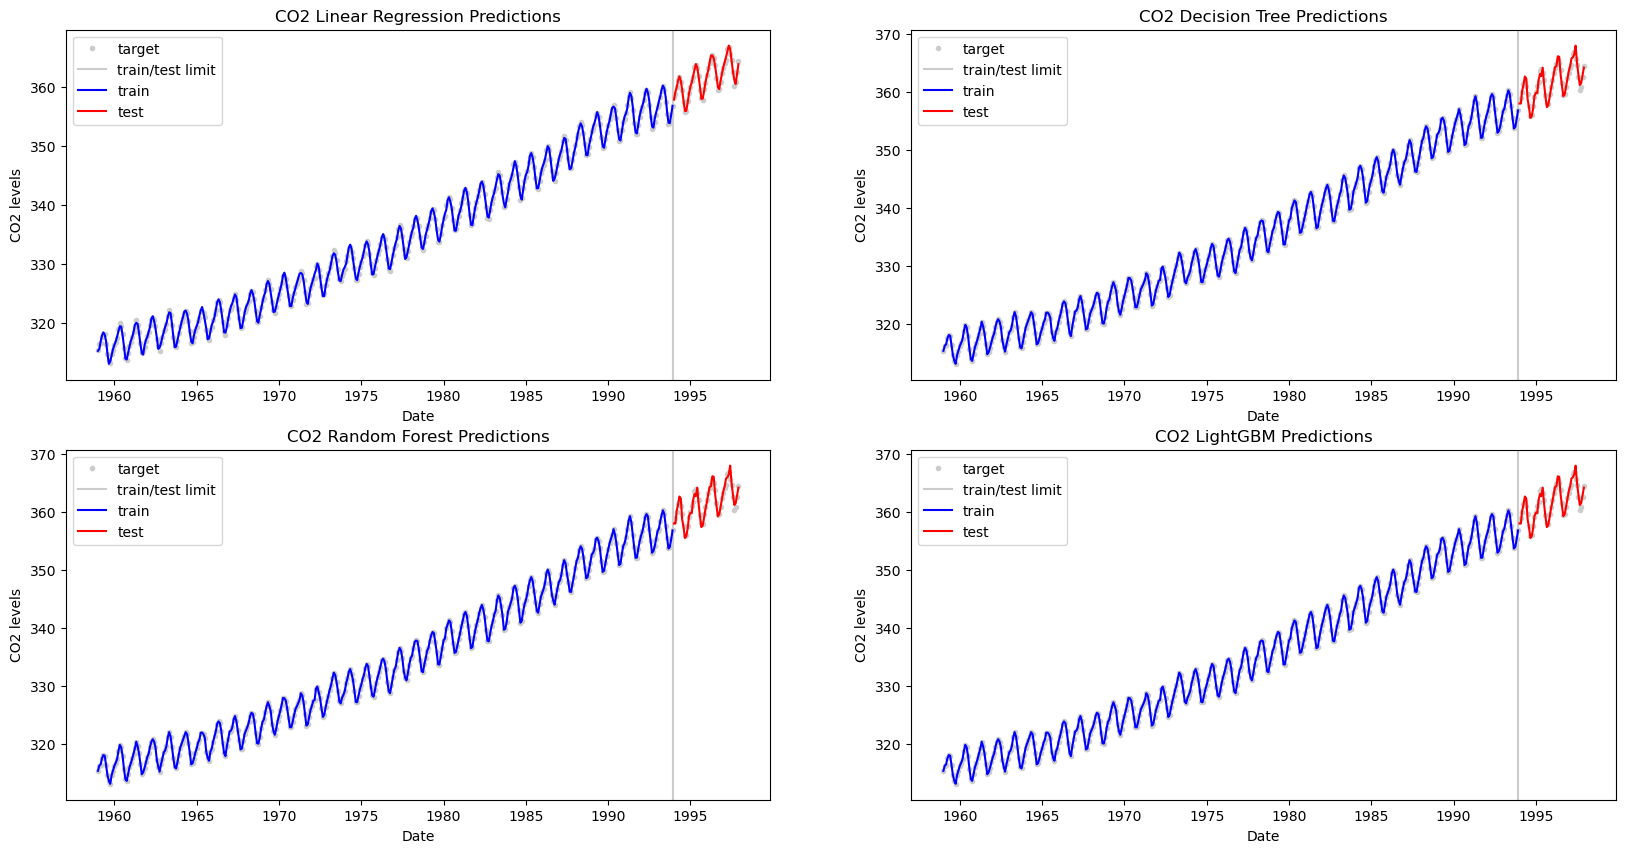

In [31]:
plot_params = {"figsize": (20,10)}
fig, axs = plt.subplots(2,2,**plot_params)

plot_predictions(y_train, y_test, y_preds[0][1], f"CO2 {y_preds[0][0]} Predictions", axs[0][0])
plot_predictions(y_train, y_test, y_preds[1][1], f"CO2 {y_preds[1][0]} Predictions", axs[0][1])
plot_predictions(y_train, y_test, y_preds[1][1], f"CO2 {y_preds[2][0]} Predictions", axs[1][0])
plot_predictions(y_train, y_test, y_preds[1][1], f"CO2 {y_preds[3][0]} Predictions", axs[1][1])

In [32]:
# Measure errors
from sklearn.metrics import mean_squared_error

In [33]:
[(y_pred[0], mean_squared_error(y_test, y_pred[1][y_test.index],squared=True)) for y_pred in y_preds]

[('Linear Regression', 0.09701147650596863),
 ('Decision Tree', 0.44914439214707147),
 ('Random Forest', 0.3365618370479167),
 ('LightGBM', 0.39957468879824676)]

# Overall conclusions
- This dataset is simple, but put a more complex one and I assure the Linear Regression + LightGBM will be awesome for this problem
- Linear Regression